# Пример запуска Нейросетевых Дифференциальных уравнений на синтетических данных

In [71]:
import os
import argparse
import logging
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

Устанавливаем библиотеку с сайта авторов: https://github.com/rtqichen/torchdiffeq

In [72]:
from torchdiffeq import odeint

Создаём классы ODEfunc, реализующий обучаемый модуль $f(\cdot)$, из уравнения $\frac{dz}{dt} = f(z(t), t, \theta)$.
В нашем случае, это будет простая трёхслойная полносвязанная нейросеть. Первый слой увеличивает размерность пространства,
второй -- содержит основное число параметров, третий -- проецирует скрытое представление обратно в пространство малой размерности.

При этом, в слои добавлена зависимость от $t$, как это требуется в исходной функции.

In [73]:
class ODEfunc(nn.Module):

    def __init__(self, dim, hidden_dim):
        super(ODEfunc, self).__init__()
        self.first = nn.Linear(dim, hidden_dim)
        self.second = nn.Linear(hidden_dim + 1, hidden_dim)
        self.third = nn.Linear(hidden_dim + 1, dim)

    def forward(self, t, x):
        out = self.first(x)
        times = torch.ones_like(x) * t
        cat_inp = torch.cat((out, times), dim=1)
        out = self.second(cat_inp)
        out = F.relu(out)
        times = torch.ones_like(x) * t
        out = F.relu(out)
        cat_inp = torch.cat((out, times), dim=1)
        out = self.third(cat_inp)
        return out

In [74]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Создаём сеть и считаем количество параметров:

In [75]:
network = ODEBlock(ODEfunc(dim=1, hidden_dim=500))

In [76]:
count_parameters(network)

252502

Обучаем архитектуру.
Возьмём синтетические данные - случайные числа от 0 до 2, будем предсказывать их квадрат.
Заметим, что 

In [77]:
optimizer = torch.optim.Adam(params=network.parameters(), lr=0.000001)

In [79]:
for i in range(20000):
    # генерируем данные
    batch = np.random.sample(size=(400, 1)) * 2
    values = batch ** 2
    batch = torch.tensor(batch, dtype=torch.float32)
    values = torch.tensor(values, dtype=torch.float32)
    
    # считаем значения и функцию потерь
    predictions = network(batch, tol=1e-3)
    loss = F.mse_loss(input=predictions, target=values)
    
    # считаем градиент ошибок по папарметрам и делаем шаг в направлении антиградиента
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print("MSE Loss (iter {}): {:.3f}".format(i, float(loss)))

# Визуализация

In [20]:
x = np.linspace(0, 2, 40)
out = network(torch.tensor(x.reshape(-1, 1), dtype=torch.float32))

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

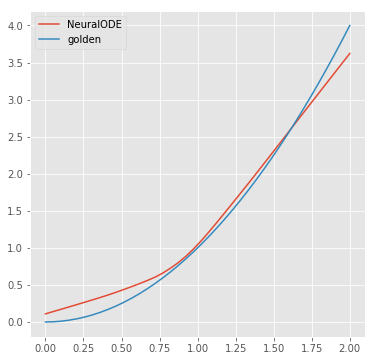

In [63]:
plt.figure(figsize=(6, 6))
plt.plot(x, out.detach().numpy(), label='NeuralODE')
plt.plot(x, x**2, label='golden')
plt.legend()
plt.show()